# Imports

In [ ]:
!pip install transformers evaluate accelerate datasets --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 11.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from transformers import (
    AutoTokenizer,
    BertForMaskedLM,
    BertConfig,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer
)
from google.colab import drive
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from datasets import load_metric
import numpy as np
import os
from tqdm import tqdm
from matplotlib import pyplot as plt

In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data

## Преобразование датасета в нужный формат (предложение, флаг полиперсональности)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/train_dataset.csv")

In [ ]:
# Фильтрация одинаковых пар предложений
df = df[df.was_changed == True].drop(["Unnamed: 0", "base", "was_changed"], axis = 1)
df.head(5)

,polypers
3,Колонизаторы душилиет всякое проявление свобод...
8,В 1922 году она окончилает историко-филологиче...
17,"Кроме того , она печатаетете короткие рассказы..."
19,Великая Отечественная война помешала Выгодской...
20,Первый год Отечественной войны Э . И . Выгодск...


# Bert stuff

Hyperparameters

In [ ]:
MODEL = "/content/drive/MyDrive/pretrained_bert_epoch_9.999976796259556.pt"
MODEL_NAME = 'DeepPavlov/rubert-base-cased'
SEQ_LEN = 64
BATCH_SIZE = 6
MLM_PROB = 0.15

Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.deprecation_warnings["Asking-to-pad-a-fast-tokenizer"] = True

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=MLM_PROB)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples, padding='max_length', truncation=True, max_length=SEQ_LEN)

Dataset

In [ ]:
class PairsDataset(Dataset):
    def __init__(self,
                 tokenizer,
                 data):
        self.dataset = data.reset_index(drop=True)
        self.dataset = self.dataset.sample(10000, random_state=42, ignore_index=True) # посмотреть на динамику обучения по части данных
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.tokenizer(self.dataset.loc[idx]["polypers"])
        # polypers_flag = self.dataset.loc[idx]["poly_flag"]

        return text #, polypers_flag

In [ ]:
data = PairsDataset(tokenize_function, df)

# Network

## BertModule

In [ ]:
VOCAB_SIZE = tokenizer.vocab_size
HID_SIZE = 768
DROPOUT = 0.15

Loading fine-tuned MLM model

In [ ]:
configuration = BertConfig.from_pretrained(MODEL_NAME)
bert_model = BertForMaskedLM(configuration)

checkpoint = torch.load(MODEL)
bert_model.load_state_dict(checkpoint['model_state_dict'])

bert_model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

Removing MLM head

In [ ]:
bert_model = bert_model.bert
bert_model.train()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

Freezing the model

In [ ]:
for param in bert_model.parameters():
    param.requires_grad = False

Defining BertModule

In [ ]:
class BertModule(nn.Module):
  def __init__(self, model = bert_model):
        super(BertModule, self).__init__()
        self.bert = model

  def forward(self, ids, mask, token_type_ids):
    output = self.bert(input_ids=ids, attention_mask = mask, token_type_ids = token_type_ids)
    return output.last_hidden_state.type(torch.float)

## MLMHead

Defining MLMHead

In [ ]:
class MLMHead(nn.Module):
  def __init__(self, vocab_size = VOCAB_SIZE, hidden_size = HID_SIZE, dropout = DROPOUT, bert_model = bert_model):
    super(MLMHead, self).__init__()
    self.linear_stack = nn.Sequential(
        nn.Linear(hidden_size, hidden_size),
        nn.GELU(),
        nn.LayerNorm((768,), eps=1e-12)
        )
    self.emb_matrix = nn.Linear(hidden_size, vocab_size)
    self.emb_matrix.weight = bert_model.embeddings.word_embeddings.weight
    self.softmax = nn.LogSoftmax(dim=-1)


  def forward(self, input):
    linear_output = self.linear_stack(input)
    emb_proj = self.emb_matrix(linear_output)
    logits = self.softmax(emb_proj)
    return logits

In [ ]:
bert_model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

## ModularLM

In [ ]:
class ModularLM(nn.Module):
    def __init__(self):
        super(ModularLM, self).__init__()
        self.bert_module = BertModule()
        self.head = MLMHead()


    def forward(self, input_ids, token_type_ids, attention_mask):
        bert_output = self.bert_module(ids = input_ids, token_type_ids = token_type_ids, mask = attention_mask)
        output = self.head(bert_output)
        return output

# Training

In [ ]:
training_args = {
    "output_dir": "ModularMLM",
    "dataloader_num_workers": 0,
    "learning_rate": 5e-5,
    "num_train_epochs": 10,
    "per_device_train_batch_size": BATCH_SIZE,
    "gradient_accumulation_steps": 4,
}

In [ ]:
dataloader = DataLoader(data, batch_size=training_args["per_device_train_batch_size"], num_workers=training_args["dataloader_num_workers"], shuffle=True, drop_last=True, collate_fn=data_collator)

In [ ]:
model_modular = ModularLM()

In [ ]:
model_modular.to(device)

ModularLM(
  (bert_module): BertModule(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(119547, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
     

In [ ]:
optimizer = torch.optim.AdamW(model_modular.parameters(), lr=training_args["learning_rate"])

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
losses = []

# Train the model
for epoch in tqdm(range(training_args["num_train_epochs"])):
    for batch_idx, batch in enumerate(tqdm(dataloader)):
        # Move the batch to the device
        input_ids = batch["input_ids"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model_modular(input_ids, token_type_ids, attention_mask)
        loss = loss_fn(torch.reshape(outputs, (BATCH_SIZE*SEQ_LEN, tokenizer.vocab_size)), torch.flatten(labels))
        losses.append(float(loss))

        # Backward pass
        loss.backward()

        # Gradient accumulation and model update
        optimizer_step_cond = ((batch_idx + 1) % training_args["gradient_accumulation_steps"] == 0) or (batch_idx == len(dataloader)-1)
        if optimizer_step_cond:
            # Update the parameters
            optimizer.step()

            # Zero the gradients
            optimizer.zero_grad()

    print(f"Epoch - {epoch + 1} : loss {loss}")

<ipython-input-100-79ab5433a37f>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(training_args["num_train_epochs"])):


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-100-79ab5433a37f>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, batch in enumerate(tqdm(dataloader)):


  0%|          | 0/1666 [00:00<?, ?it/s]

Epoch - 1 : loss 4.781351089477539


  0%|          | 0/1666 [00:00<?, ?it/s]

Epoch - 2 : loss 5.7100067138671875


  0%|          | 0/1666 [00:00<?, ?it/s]

Epoch - 3 : loss 4.066597938537598


  0%|          | 0/1666 [00:00<?, ?it/s]

Epoch - 4 : loss 4.274369716644287


  0%|          | 0/1666 [00:00<?, ?it/s]

Epoch - 5 : loss 5.614792346954346


  0%|          | 0/1666 [00:00<?, ?it/s]

Epoch - 6 : loss 2.80643367767334


  0%|          | 0/1666 [00:00<?, ?it/s]

Epoch - 7 : loss 2.832484006881714


  0%|          | 0/1666 [00:00<?, ?it/s]

Epoch - 8 : loss 3.8414993286132812


  0%|          | 0/1666 [00:00<?, ?it/s]

Epoch - 9 : loss 3.3714311122894287


  0%|          | 0/1666 [00:00<?, ?it/s]

Epoch - 10 : loss 2.7217905521392822


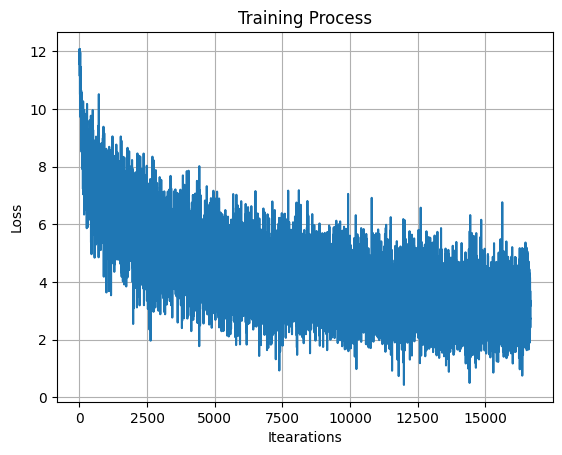

In [ ]:
plt.title('Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [ ]:
# Save the model
torch.save({
            'epoch': epoch,
            'model_state_dict': model_modular.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "modular_ml_4.1_polypers_10ep.pt")

# Test

In [ ]:
def evaluate(model, dataloader, loss_fn = loss_fn, device = device):
    """
    Evaluate the model on a given dataset.

    Args:
        model (torch.nn.Module): The model to evaluate.
        dataloader (torch.utils.data.DataLoader): The data loader for the dataset.
        loss_fn (torch.nn.modules.loss._Loss): The loss function to use.
        device (torch.device): The device to use for evaluation.

    Returns:
        float: The average loss on the dataset.
    """

    model.eval()  # Set the model to evaluation mode

    losses = []  # List to store the losses

    with torch.no_grad():  # Disable gradient calculation
        for batch in tqdm(dataloader):
            # Move the batch to the device
            input_ids = batch["input_ids"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, token_type_ids, attention_mask)
            loss = loss_fn(torch.reshape(outputs, (BATCH_SIZE*SEQ_LEN, tokenizer.vocab_size)), torch.flatten(labels))

            losses.append(float(loss))

    return sum(losses) / len(losses)  # Return the average loss

In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/test_dataset.csv")

In [ ]:
# Фильтрация одинаковых пар предложений
df_test = df_test[df_test.was_changed == True].drop(["Unnamed: 0", "base", "was_changed"], axis = 1)
df_test.head(5)

,polypers
1,Я смотрел на топчанчик и не сразу заметилет до...
10,"Очнувшись , я увидел , что Гюнтер яростно тащи..."
12,И у всех — чтоб их чорт дралете ! — друзей-при...
15,Но он перекрывалет свою слабость развитым слух...
19,"Он внимательно слушалет канонаду , этот « быва..."


In [ ]:
test_data = PairsDataset(tokenize_function, df_test)

In [ ]:
test_dataloader = DataLoader(test_data, batch_size=training_args["per_device_train_batch_size"], num_workers=training_args["dataloader_num_workers"], shuffle=True, drop_last=True, collate_fn=data_collator)

In [ ]:
print(evaluate(model_modular, test_dataloader))

<ipython-input-72-57fecc52bc99>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(dataloader):


  0%|          | 0/1666 [00:00<?, ?it/s]

3.052909358530915
